In [3]:
import pandas as pd
import numpy as np
from scipy.stats import pointbiserialr
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi
import scipy
from scipy.stats import pearsonr
from seaborn import regplot
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy as sa
from sqlalchemy import create_engine
from sqlalchemy.engine import URL

# Problem Statement
### _Business Problem_
"Dream Housing Finance company deals in all home loans. They have presence across all urban, semi urban and rural areas. Customer first apply for home loan after that company validates the customer eligibility for loan. Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers."

### _Translate Business Problem into Data Science / Machine Learning problem_
This is a classification problem where we have to predict whether a loan will be approved or not. Specifically, it is a binary classification problem where we have to predict either one of the two classes given i.e. approved (Y) or not approved (N). Another way to frame the problem is to predict whether the loan will likely to default or not, if it is likely to default, then the loan would not be approved, and vice versa. The dependent variable or target variable is the Loan_Status, while the rest are independent variable or features. We need to develop a model using the features to predict the target variable.

# Hypothesis Generation
Hypothesis Generation is the process of listing out all the possible factors that can affect the outcome i.e. which of the features will have an impact on whether a loan will be approved or not. Some of the hypothesis are:

- Education - Applicants with higher education level i.e. graduate level should have higher chances of loan approval<br>
- Income: Applicants with higher income should have more chances of loan approval<br>
-  Loan amount: If the loan amount is less, the chances of loan approval should be high<br>
- Loan term: Loans with shorter time period should have higher chances of approval<br>
- Previous credit history: Applicants who have repayed their previous debts should have higher chances of loan approval<br>
- Monthly installment amount: If the monthly installment amount is low, the chances of loan approval should be high
And so on<br>

Some of the hypothesis seem intuitive while others may not. We will try to validate each of these hypothesis based on the dataset.<br>

In [4]:
train = pd.read_csv("train_co_relation.csv")
# train_original = train.copy()

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [4]:
# take a look at the top 5 rows of the train set, notice the column "Loan_Status"
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001585,NaN,Yes,3+,Graduate,No,51763,0.0,700.0,300.0,1.0,Urban,Y
1,LP001469,Male,No,0,Graduate,Yes,20166,0.0,650.0,480.0,NaN,Urban,Y
2,LP001536,Male,Yes,3+,Graduate,No,39999,0.0,600.0,180.0,0.0,Semiurban,Y
3,LP002813,Female,Yes,1,Graduate,Yes,19484,0.0,600.0,360.0,1.0,Semiurban,Y
4,LP002191,Male,Yes,0,Graduate,No,19730,5266.0,570.0,360.0,1.0,Rural,N


In [5]:
# percentage distribution can be calculated by setting the normalize=True to show proportions instead of number 
train['Loan_Status'].value_counts(normalize=True)

Loan_Status
Y    0.687296
N    0.312704
Name: proportion, dtype: float64

The loan of around 69% was approved.

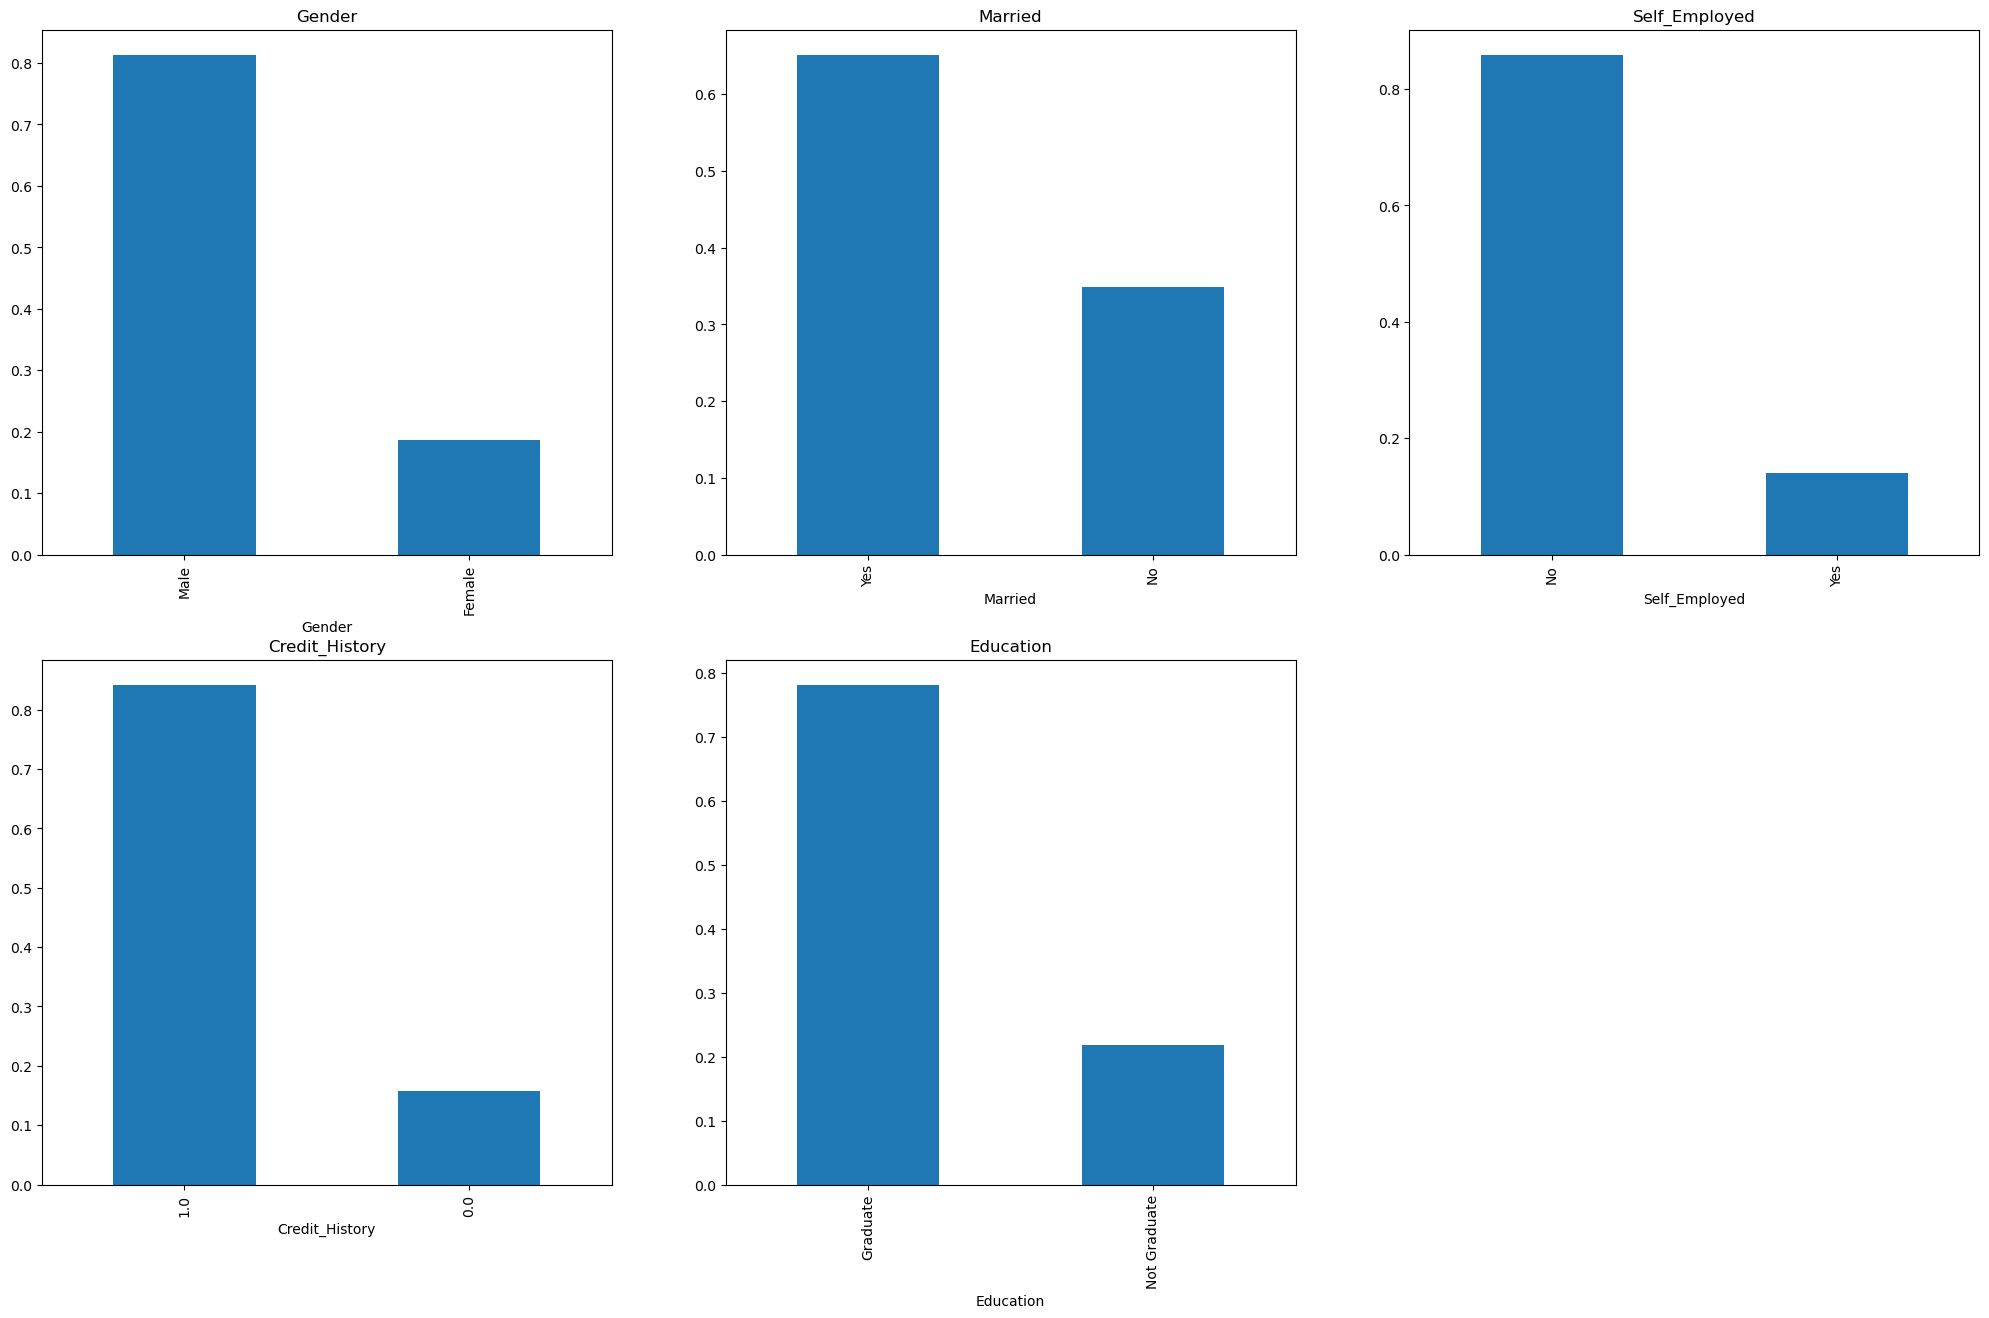

In [6]:
# Visualizing categorical features
# plt.figure(1)
plt.subplot(231)
train['Gender'].value_counts(normalize=True).plot.bar(figsize=(25,15), title= 'Gender')

plt.subplot(232)
train['Married'].value_counts(normalize=True).plot.bar(title= 'Married')

plt.subplot(233)
train['Self_Employed'].value_counts(normalize=True).plot.bar(title= 'Self_Employed')

plt.subplot(234)
train['Credit_History'].value_counts(normalize=True).plot.bar(title= 'Credit_History')

plt.subplot(235)
train['Education'].value_counts(normalize=True).plot.bar(title= 'Education')

plt.show()

It can be inferred from the above bar plots that:

- 80% applicants in the dataset are male.
- Around 65% of the applicants in the dataset are married.
- Around 15% applicants in the dataset are self employed.
- Around 85% applicants have credit history (repaid their debts).
- Around 80% of the applicants are Graduate.

### Question: Can you visualize Dependents and property area distribution?

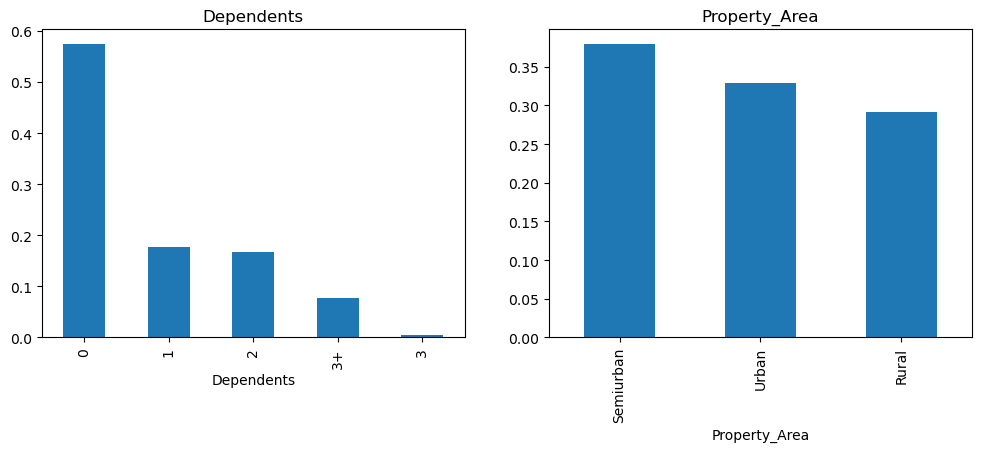

In [7]:
# Visualizing remaining categorical features
# plt.figure(1)
plt.subplot(121)
train['Dependents'].value_counts(normalize=True).plot.bar(figsize=(12,4), title= 'Dependents')

plt.subplot(122)
train['Property_Area'].value_counts(normalize=True).plot.bar(title= 'Property_Area')

plt.show()

Following inferences can be made from the above bar plots:

- More than half of the applicants don’t have any dependents.
- Most of the applicants are from Semiurban area.


### Independent Variable (Numerical)
There are 4 features that are Numerical: These features have numerical values (ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term)

Firstly, let’s look at the Applicant income distribution:

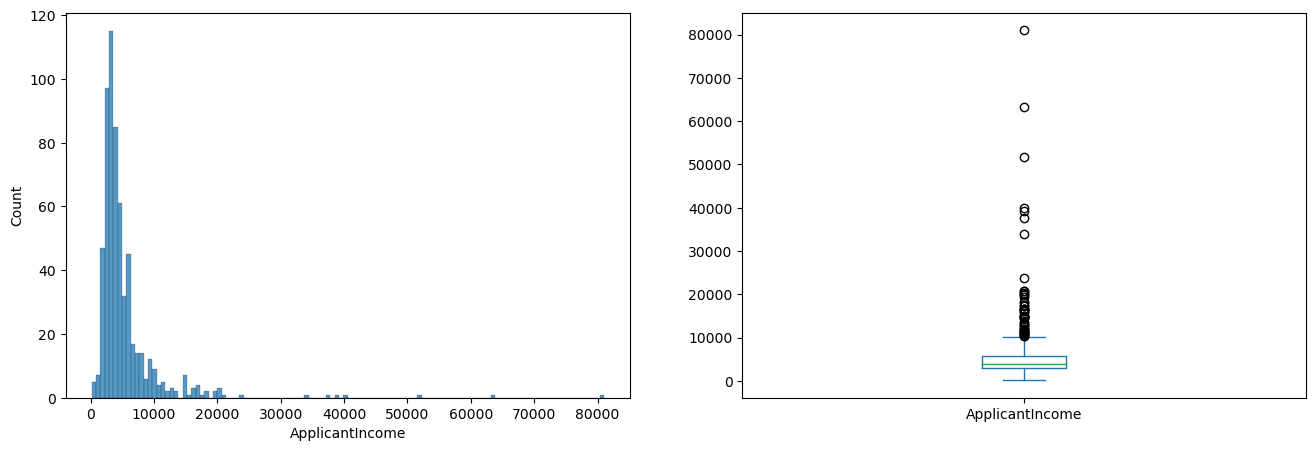

In [8]:
# Visualizing ApplicantIncome
# plt.figure(1)
plt.subplot(121)
sns.histplot(train['ApplicantIncome']);

plt.subplot(122)
train['ApplicantIncome'].plot.box(figsize=(16,5))

plt.show()

It can be inferred that most of the data in the distribution of applicant income is towards left which means it is not normally distributed. The distribution is right-skewed (positive skewness). We will try to make it normal in later sections as algorithms works better if the data is normally distributed.

The boxplot confirms the presence of a lot of outliers/extreme values. This can be attributed to the income disparity in the society. Part of this can be driven by the fact that we are looking at people with different education levels. Let us segregate them by Education:

<Axes: title={'center': 'ApplicantIncome'}, xlabel='Education'>

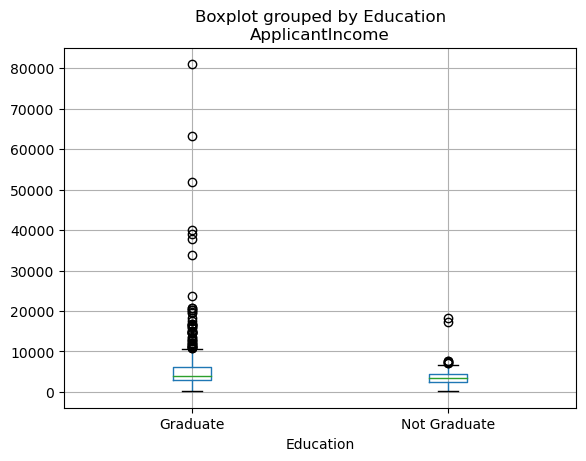

In [9]:
train.boxplot(column='ApplicantIncome', by = 'Education')
# plt.suptitle("")

### Question: Can you plot coapplicant income?

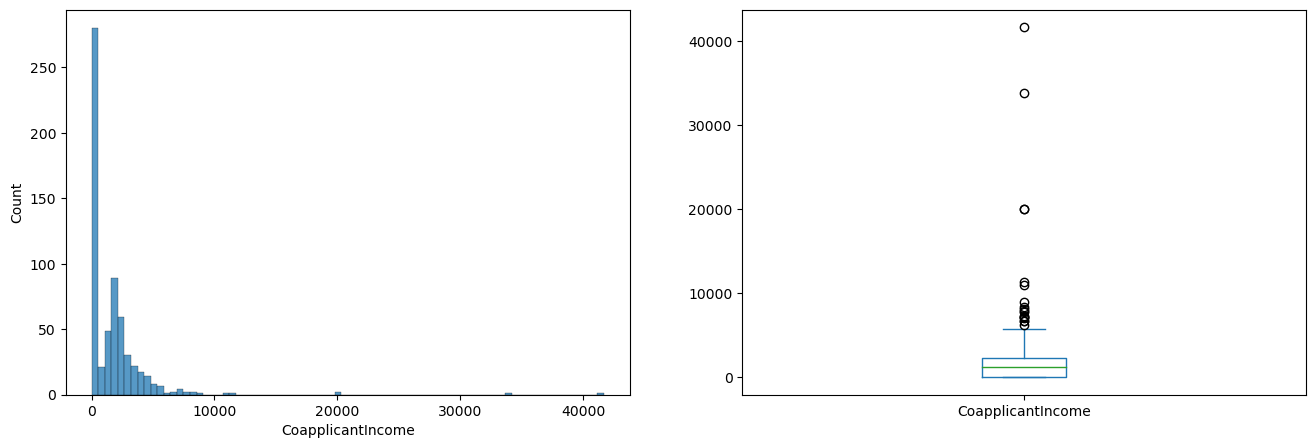

In [10]:
# plt.figure(1)
plt.subplot(121)
sns.histplot(train['CoapplicantIncome']);

plt.subplot(122)
train['CoapplicantIncome'].plot.box(figsize=(16,5))

plt.show()

<Axes: title={'center': 'CoapplicantIncome'}, xlabel='Education'>

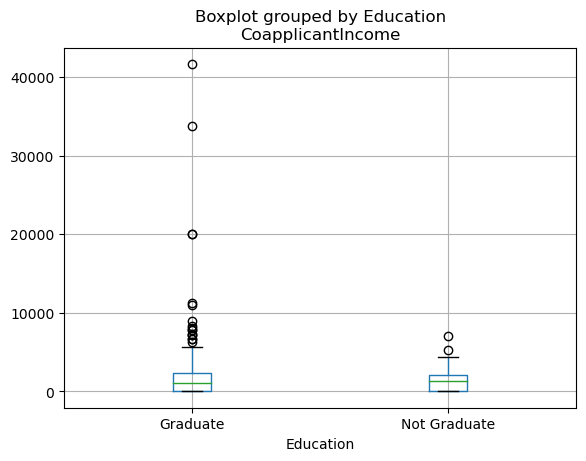

In [11]:
train.boxplot(column='CoapplicantIncome', by = 'Education')
###plt.suptitle("")

We can see that there are a higher number of graduates with very high incomes, which are appearing to be the outliers.

Secondly, Let’s look at the Coapplicant income distribution.

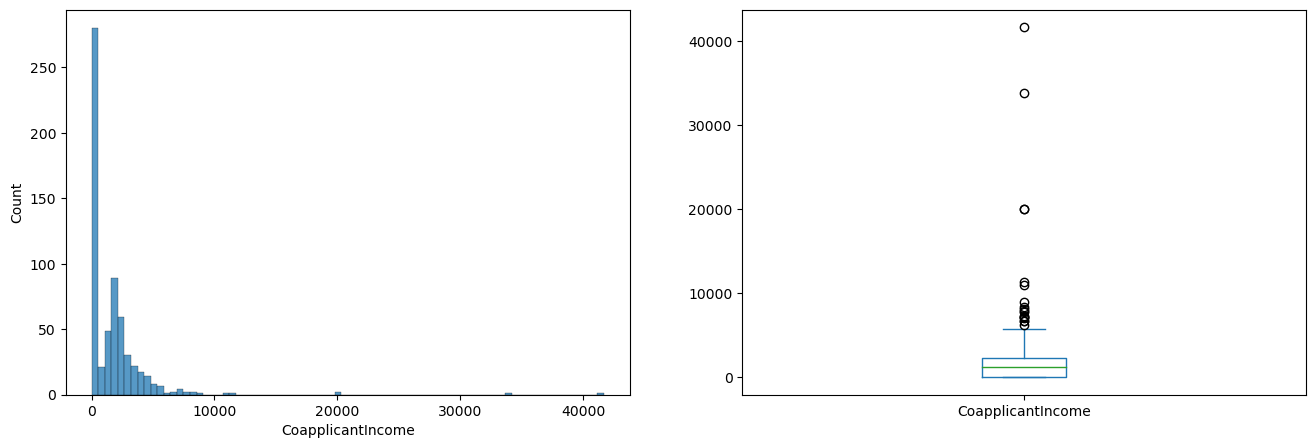

In [12]:
# plt.figure(1)
plt.subplot(121)
sns.histplot(train['CoapplicantIncome']);

plt.subplot(122)
train['CoapplicantIncome'].plot.box(figsize=(16,5))

plt.show()

We see a similar distribution as that of the applicant income. Majority of coapplicant’s income ranges from 0 to 5000. We also see a lot of outliers in the coapplicant income and it is not normally distributed.

Thirdly, let’s look at the distribution of LoanAmount variable.

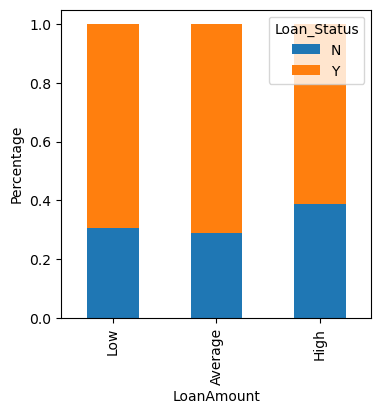

In [5]:
bins=[0,100,200,700]
group=['Low','Average','High']
train['LoanAmount_bin']=pd.cut(train['LoanAmount'],bins,labels=group)

LoanAmount_bin = pd.crosstab(train['LoanAmount_bin'],train['Loan_Status'])
LoanAmount_bin.div(LoanAmount_bin.sum(1).astype(float), axis = 0).plot(kind="bar", stacked=True, figsize=(4,4))
plt.xlabel('LoanAmount')
p = plt.ylabel('Percentage')

You can see that the proportion of approved loans is higher for Low and Average Loan Amounts as compared to that of the High Loan Amount. This appears to support our hypothesis that the chance of loan approval will be higher when the loan amount is less.

Loan_Status    N    Y
Gender               
Female        37   75
Male         150  339


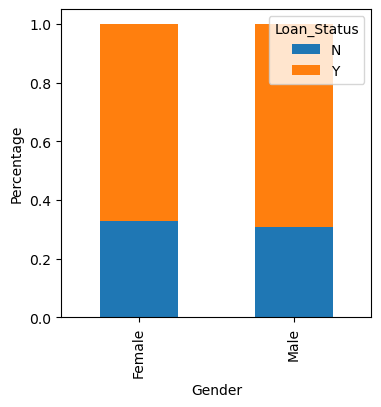

In [13]:
print(pd.crosstab(train['Gender'],train['Loan_Status']))

Gender = pd.crosstab(train['Gender'],train['Loan_Status'])
Gender.div(Gender.sum(1).astype(float), axis = 0).plot(kind="bar", stacked=True, figsize=(4,4))
plt.xlabel('Gender')
p = plt.ylabel('Percentage')

In the case of classification problems where input variables are also categorical, we can use statistical tests to determine whether the output variable is dependent or independent of the input variables. If independent, then the input variable is a candidate for a feature that may be irrelevant to the problem and removed from the dataset.

### The Contingency Table 
The Contingency table (also called crosstab) is used in statistics to summarise the relationship between several categorical variables. Here, we are taking a table that shows the number of men and women getting loan


#### Null Hypothesis 
A null Hypothesis is a general statistical statement or assumption about a population parameter that is assumed to be true Until we have sufficient evidence to reject it. It is generally denoted by Ho.

#### Alternate Hypothesis
 The Alternate Hypothesis is considered as competing of the null hypothesis. It is generally denoted by H1. The general goal of our hypothesis testing is to test the Alternative hypothesis against the null hypothesis. It is generally denoted by H1.

#### P-Value 
A P-value is used as a measure of evidence against the null hypothesis. If it is greater than our level of significance then we will accept our null hypothesis.

<b>Null hypothesis: We start by defining our null hypothesis (H0) which states that there is no relation between the variables. 

<b>Alternate hypothesis: It would state that there is a significant relationship between the two variables. 


Generally, a Critical Value or alpha value of 0.05 is chosen.This alpha value denotes the probability of erroneously rejecting H0 when it is true. A lower alpha value is chosen in cases when we expect more precision. If the p-value for the test comes out to be strictly greater than the alpha value, then we will accept our H0.

If P-value >= Critical Value: significant result, accept null hypothesis (H0), independent.<br>
If P-value < Critical Value: not significant result, reject null hypothesis (H0), dependent.<br>




In [14]:
from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(Gender)
print(stat, p, dof, expected)

0.13962612116543877 0.7086529816451106 1 [[ 34.84858569  77.15141431]
 [152.15141431 336.84858569]]


In [15]:
 def interpret_p_value(p):
    alpha = 0.05
    print("p value is ",p)
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (H0 holds true)')
    

In [16]:
interpret_p_value(p)

p value is  0.7086529816451106
Independent (H0 holds true)


### Question: Does marital status affects loan approval?

In [18]:
print(pd.crosstab(train['Married'], train['Loan_Status']))

Married = pd.crosstab(train['Married'],train['Loan_Status'])
# Married.div(Married.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(4,4))
# plt.xlabel('Married')
# p = plt.ylabel('Percentage')

Loan_Status    N    Y
Married              
No            79  134
Yes          113  285


In [19]:
stat, p, dof, expected = chi2_contingency(Married)
print(p)
interpret_p_value(p)

0.03439381301579988
p value is  0.03439381301579988
Dependent (reject H0)


### Question: Does number of dependents affect loan approval?

Loan_Status    N    Y
Dependents           
0            107  237
1             38   68
2             25   75
3              0    3
3+            16   30


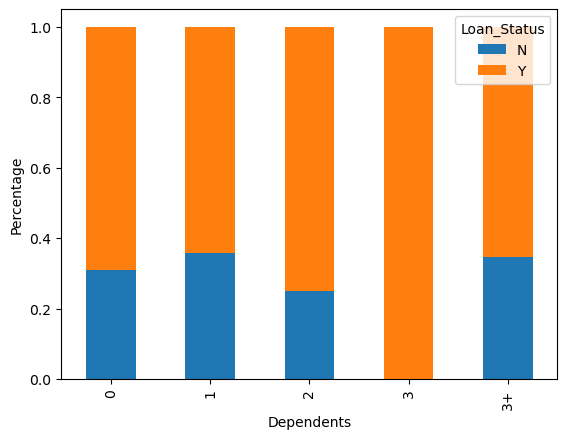

In [20]:
print(pd.crosstab(train['Dependents'],train['Loan_Status']))

Dependents=pd.crosstab(train['Dependents'],train['Loan_Status'])
Dependents.div(Dependents.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.xlabel('Dependents')
p = plt.ylabel('Percentage')

In [21]:
stat, p, dof, expected = chi2_contingency(Dependents)
print(stat, p)
interpret_p_value(p)

4.5006606424861895 0.3424691519071323
p value is  0.3424691519071323
Independent (H0 holds true)


Loan_Status     N    Y
Education             
Graduate      140  340
Not Graduate   52   82


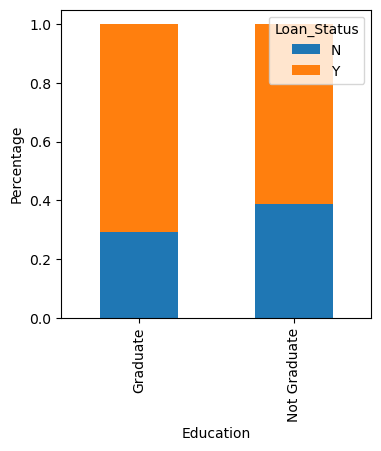

In [22]:
print(pd.crosstab(train['Education'],train['Loan_Status']))

Education=pd.crosstab(train['Education'],train['Loan_Status'])
Education.div(Education.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(4,4))
plt.xlabel('Education')
p = plt.ylabel('Percentage')

In [23]:
stat, p, dof, expected = chi2_contingency(Education)
print(stat, p)
interpret_p_value(p)

4.091490413303621 0.04309962129357355
p value is  0.04309962129357355
Dependent (reject H0)


Loan_Status      N    Y
Self_Employed          
No             157  343
Yes             26   56


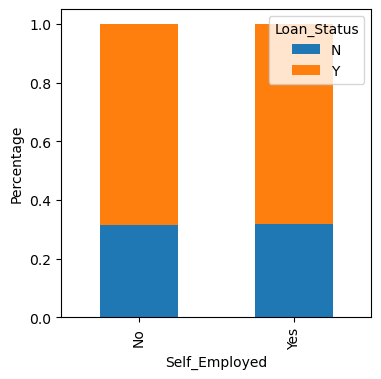

In [24]:
print(pd.crosstab(train['Self_Employed'],train['Loan_Status']))

Self_Employed=pd.crosstab(train['Self_Employed'],train['Loan_Status'])
Self_Employed.div(Self_Employed.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(4,4))
plt.xlabel('Self_Employed')
p = plt.ylabel('Percentage')

Loan_Status      N    Y
Credit_History         
0.0             82    7
1.0             97  378


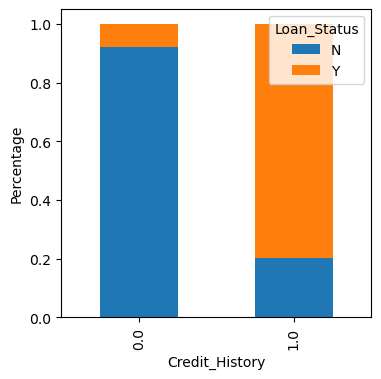

In [25]:
print(pd.crosstab(train['Credit_History'],train['Loan_Status']))

Credit_History=pd.crosstab(train['Credit_History'],train['Loan_Status'])
Credit_History.div(Credit_History.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(4,4))
plt.xlabel('Credit_History')
p = plt.ylabel('Percentage')

In [26]:
stat, p, dof, expected = chi2_contingency(Credit_History)
print(stat, p)
interpret_p_value(p)

174.63729658142535 7.184759548750746e-40
p value is  7.184759548750746e-40
Dependent (reject H0)


Loan_Status     N    Y
Property_Area         
Rural          69  110
Semiurban      54  179
Urban          69  133


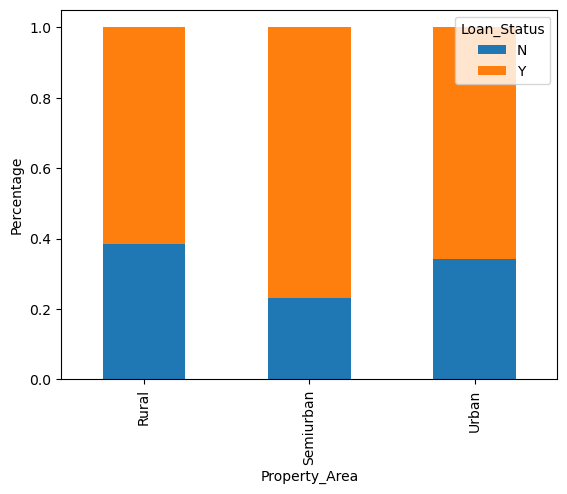

In [27]:
print(pd.crosstab(train['Property_Area'],train['Loan_Status']))

Property_Area=pd.crosstab(train['Property_Area'],train['Loan_Status'])
Property_Area.div(Property_Area.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.xlabel('Property_Area')
P = plt.ylabel('Percentage')

In [28]:
stat, p, dof, expected = chi2_contingency(Property_Area)
print(stat, p)
interpret_p_value(p)

12.297623130485675 0.0021360187811644937
p value is  0.0021360187811644937
Dependent (reject H0)


From the bar charts above, it can be inferred that:
- proportion of male and female applicants is more or less same for both approved and unapproved loans
- proportion of married applicants is higher for the approved loans
- distribution of applicants with 1 or 3+ dependents is similar across both the categories of Loan_Status
- there is nothing significant we can infer from Self_Employed vs Loan_Status plot.
- proportion of loans getting approved for graduates is higher compared to non-graduates
- it seems people with credit history as 1 are more likely to get their loans approved
- proportion of loans getting approved in semiurban area is higher as compared to that in rural or urban areas.

Now let’s visualize numerical independent variables with respect to target variable.

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [30]:
# replacing Y and N in Loan_Status variable with 1 and 0 respectively
train['Loan_Status'].replace('N', 0, inplace=True)
train['Loan_Status'].replace('Y', 1, inplace=True)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
ApplicantIncome,1.000000,-0.116605,0.570909,-0.045306,-0.014715,-0.004710
CoapplicantIncome,-0.116605,1.000000,0.188619,-0.059878,-0.002056,-0.059187
LoanAmount,0.570909,0.188619,1.000000,0.039447,-0.008433,-0.037318
Loan_Amount_Term,-0.045306,-0.059878,0.039447,1.000000,0.001470,-0.021268
Credit_History,-0.014715,-0.002056,-0.008433,0.001470,1.000000,0.561678
Loan_Status,-0.004710,-0.059187,-0.037318,-0.021268,0.561678,1.000000


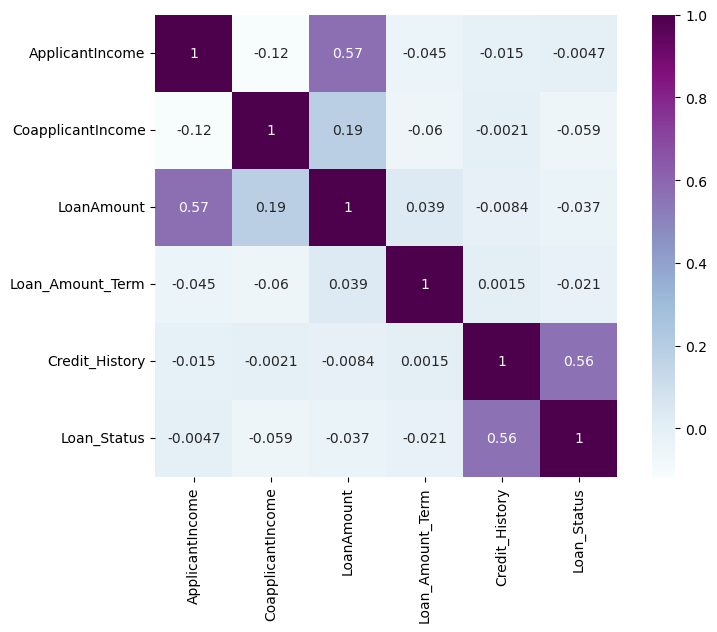

In [31]:
# calculate and visualize correlation matrix
matrix = train[['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History','Loan_Status']].corr()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(matrix, vmax=1, square=True, cmap="BuPu", annot=True)

matrix

**Note: ** We see that the most correlated variables are

(ApplicantIncome - LoanAmount) with correlation coefficient of 0.57
(Credit_History - Loan_Status) with correlation coefficient of 0.56
LoanAmount is weakly correlated with CoapplicantIncome with correlation coefficient of 0.19.

<Axes: >

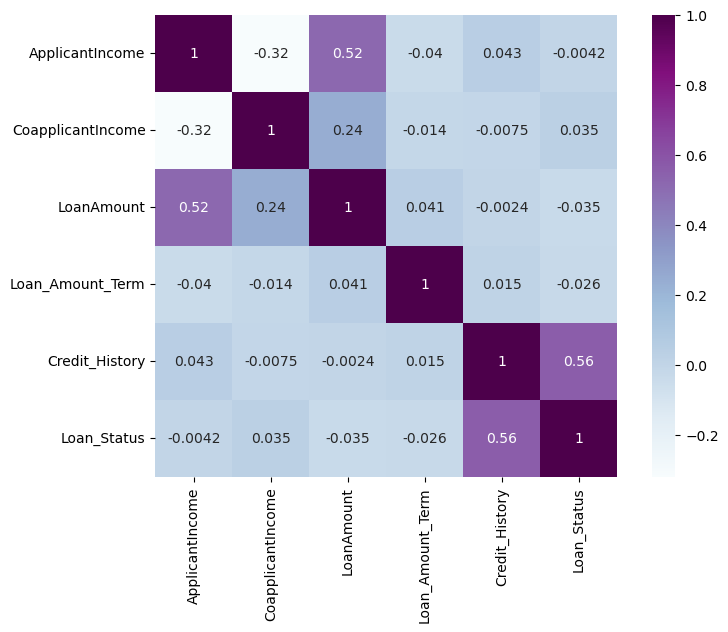

In [32]:
# calculate and visualize correlation matrix
matrix = train[['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History','Loan_Status']].corr(method='spearman')
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(matrix, vmax=1, square=True, cmap="BuPu", annot=True)

<Axes: >

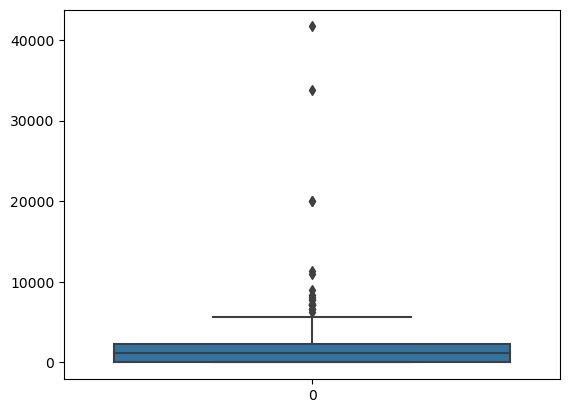

In [33]:
sns.boxplot(train['CoapplicantIncome'])

<Axes: >

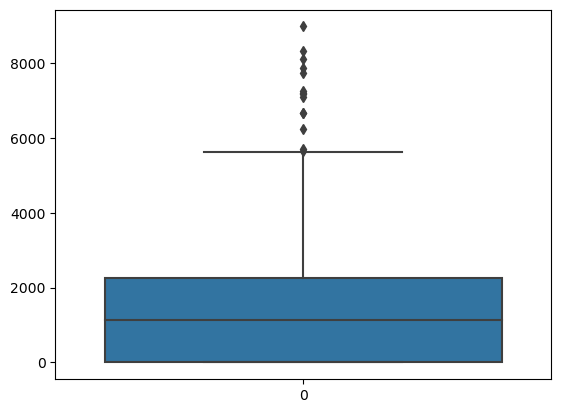

In [34]:
sns.boxplot(train.loc[train['CoapplicantIncome']<10000,'CoapplicantIncome'])

In [35]:
# making bins for Coapplicant income variable
bins = [0,1000,2000,20000]
group = ['Low','Average','High']
train['Coapplicant_Income_bin'] = pd.cut(train['CoapplicantIncome'],bins,labels=group)

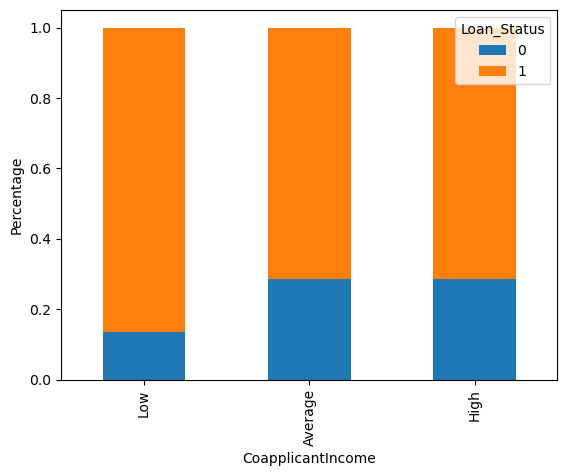

In [36]:
# plot the chart
Coapplicant_Income_bin = pd.crosstab(train['Coapplicant_Income_bin'],train['Loan_Status'])
Coapplicant_Income_bin.div(Coapplicant_Income_bin.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.xlabel('CoapplicantIncome')
P = plt.ylabel('Percentage')

In [37]:
print(len(train[train["CoapplicantIncome"] == 0]))
"Percentage of CoapplicantIncome = 0 is:",  len(train[train["CoapplicantIncome"] == 0])/len(train["CoapplicantIncome"])

273


('Percentage of CoapplicantIncome = 0 is:', 0.44462540716612375)

It shows that if coapplicant’s income is less the chances of loan approval are high. But this does not look right. The possible reason behind this may be that most of the applicants don’t have any coapplicant, so the coapplicant income for such applicants is 0 and hence the loan approval is not dependent on it. So we can make a new variable in which we will combine the applicant’s and coapplicant’s income to visualize the combined effect of income on loan approval.

Let us combine the Applicant Income and Coapplicant Income and see the combined effect of Total Income on the Loan_Status.

In [38]:
# create a new variable
train['Total_Income'] = train['ApplicantIncome'] + train['CoapplicantIncome']

<Axes: >

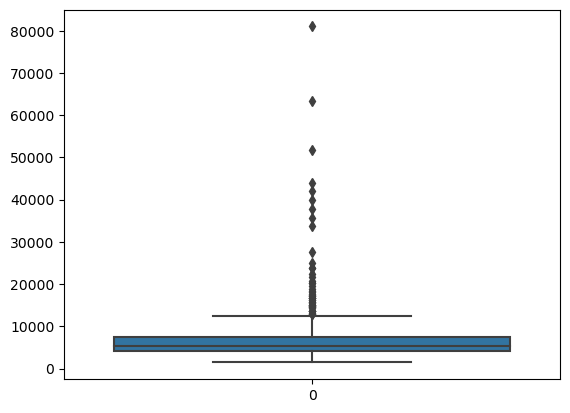

In [39]:
sns.boxplot(train.loc[train['Total_Income']>0,'Total_Income'])

In [40]:
# making bins for Total Income variable
bins = [0,2500,5000,20000,50000]
group = ['Low','Average','High', 'Very high']
train['Total_Income_bin'] = pd.cut(train['Total_Income'],bins,labels=group)

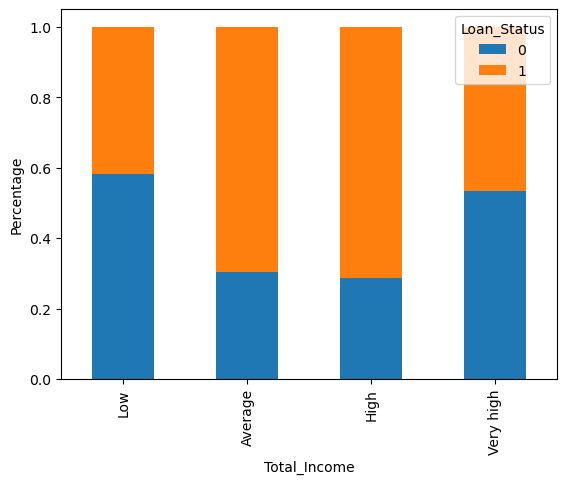

In [41]:
# plot the chart
Total_Income_bin = pd.crosstab(train['Total_Income_bin'],train['Loan_Status'])
Total_Income_bin.div(Total_Income_bin.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.xlabel('Total_Income')
P = plt.ylabel('Percentage')

We can see that Proportion of loans getting approved for applicants having low Total_Income is very less as compared to that of applicants with Average, High and Very High Income. This is more consistent with our hypothesis with applicants with high income will have more chances of loan approval.

Let’s visualize the Loan amount variable.

<Axes: >

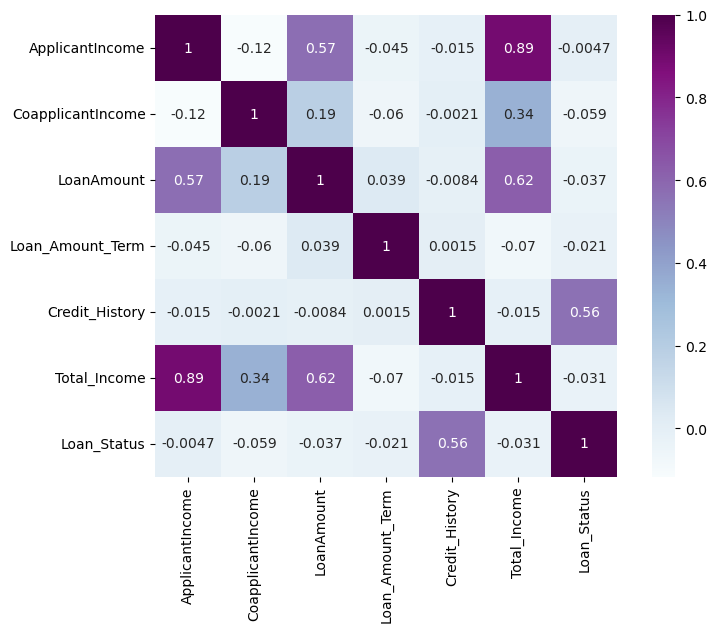

In [42]:
# calculate and visualize correlation matrix
matrix = train[['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History','Total_Income','Loan_Status']].corr()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(matrix, vmax=1, square=True, cmap="BuPu", annot=True)